In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [2]:
orig_df=pd.read_csv('customers.csv',encoding = "ISO-8859-1")

In [3]:
df = orig_df.copy()

In [4]:
df.head()

,SubscriberKey,EmailDomain,AccountCreatedDate,ProductType,BilledAmount,StartDate,EndDate,BeginningState,EndingState,TenureMonth,...,PercOfflineView,DaysSinceLastLogin,ViewMinPerDay,ViewMinPerActiveDay,ClipsPerDay,ClipsPerActiveDay,NCoursesPerDay,CourseCompletionRate,MaxCourseCompletionRate,CoursePillar
0,5,social-media-productions,10/10/13,STD,29.00,4/17/15,5/17/15,Renewal,Renewed,19,...,0.0,13.0,10.737255,60.844444,6.941176,39.333333,0.176471,0.212801,0.419307,Software Development
1,13,hotmail,4/16/10,PLUS,16.81,6/30/15,8/1/15,Reactivation,Renewed,64,...,0.0,3.0,10.529825,22.229630,3.368421,7.111111,0.157895,0.190862,0.404102,Software Development
2,28,hotmail,9/6/12,STD,29.00,4/28/15,5/28/15,Renewal,Renewed,33,...,0.0,29.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,None
3,51,gmail,12/8/13,STD,29.00,5/11/15,6/11/15,Renewal,Renewed,18,...,0.0,11.0,1.068519,19.233333,0.277778,5.000000,0.055556,0.116957,0.116957,Software Development
4,56,live,7/11/13,PLUS,49.00,8/23/15,9/23/15,Renewal,Renewed,26,...,0.0,2.0,1.725926,31.066667,0.333333,6.000000,0.055556,0.139678,0.139678,IT Pro


In [5]:
##let's check the nulls
df.isnull().sum(axis = 0)

SubscriberKey                    0
EmailDomain                      0
AccountCreatedDate               0
ProductType                      0
BilledAmount                     0
StartDate                        0
EndDate                          0
BeginningState                   0
EndingState                      0
TenureMonth                      0
Channel                       8530
AutoRenewOn                    183
NActiveMonths                    0
NContinuousActiveMonths          0
MaxContinuousActiveMonths        0
CountryCode                     29
Company                      23829
StartTrial                       0
NPrevChurns                      0
TurnAutoRenewOff                 0
PercActiveDay                    0
PercOfflineView                  0
DaysSinceLastLogin             633
ViewMinPerDay                    0
ViewMinPerActiveDay              0
ClipsPerDay                      0
ClipsPerActiveDay                0
NCoursesPerDay                   0
CourseCompletionRate

In [6]:
##Come back to this
#from scipy import stats
#stats.chisquare(df['DaysSinceLastLogin'],f_exp=df['churn'])

In [7]:
##days since last login has correlation of -0.05. Might be useful.
##Will bucket the data and treat as a categorical input.
df['DaysSinceLastLogin_Bucket']= pd.cut(x = df['DaysSinceLastLogin'],bins=[0,7,14,21,28,60,500],labels=['0 days','7U days','14U days','21U days','28U days','60U Days']).values.add_categories('missing')
df['DaysSinceLastLogin_Bucket'] = df['DaysSinceLastLogin_Bucket'].fillna(value="missing").astype('object')

df = df.drop(columns = ['DaysSinceLastLogin'])

In [8]:
##all other missing variables belong to categorical columns so can just fill in with value
df = df.fillna(value="missing")

In [9]:
#Create Churn Output Variable
df['churn'] = df['EndingState'].apply(lambda x: 0 if x in ['Renewed','Changed'] else 1 )

df = df.drop(columns=['EndingState'])

In [10]:
## Which string fields have too many values to use as model features
df.select_dtypes('object').nunique()

EmailDomain                  12476
AccountCreatedDate            1928
ProductType                      2
StartDate                      181
EndDate                         29
BeginningState                   5
Channel                         10
AutoRenewOn                      3
CountryCode                    156
Company                      14324
CoursePillar                     4
DaysSinceLastLogin_Bucket        7
dtype: int64

In [11]:
#What's the correlation between churn and other variables?
df[df.columns[1:]].corr()['churn'][:]

BilledAmount                -0.094614
TenureMonth                 -0.119498
NActiveMonths               -0.021309
NContinuousActiveMonths     -0.069668
MaxContinuousActiveMonths   -0.020910
StartTrial                   0.070289
NPrevChurns                  0.124659
TurnAutoRenewOff             0.464773
PercActiveDay                0.043576
PercOfflineView             -0.009682
ViewMinPerDay                0.052278
ViewMinPerActiveDay          0.051103
ClipsPerDay                  0.061753
ClipsPerActiveDay            0.067096
NCoursesPerDay               0.056017
CourseCompletionRate         0.046352
MaxCourseCompletionRate      0.046330
churn                        1.000000
Name: churn, dtype: float64

In [12]:
##subset columns based on threshold for cols that can be used as feature or need to be grouped
##to top N
value_threshold = 10

long_tail_cols = df.select_dtypes('object').nunique() > value_threshold
feature_cols = df.select_dtypes('object').nunique() <= value_threshold

long_tail_cols = long_tail_cols[long_tail_cols==True].index
feature_cols = feature_cols[feature_cols==True].index


In [13]:
##DF of categorical columns
cat_df =df[feature_cols]

In [14]:
#Lets try to create features from those columns by taking the top n values and grouping as "other" all the other ones
values_to_group = long_tail_cols

top = 10
long_tail_df = pd.DataFrame()

for value in values_to_group:
    long_tail_df[value + "_top_"+ str(top)]=np.where(df[value].isin(df[value].value_counts().index[:top]), df[value], 'Other')
 

##turn the step data into dummy data 
long_tail_dummy_df = pd.get_dummies(long_tail_df, drop_first=True)
features_dummy_df = pd.get_dummies(cat_df, drop_first=True)
numerical_df = df.select_dtypes(exclude=['object']).drop(columns=['churn'])

##compile your input and output dataframes
X = pd.concat([features_dummy_df,long_tail_dummy_df,numerical_df],axis=1)
y = df.churn

In [15]:

#split your data into training and test sets to test accuracy of model on unfitted results
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)


In [16]:
##Create and try a few different models

#neural network
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(40, 4), random_state=2)
mlp.fit(X_train, y_train)

#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
rfm = RandomForestClassifier(max_depth=2, random_state=0)
rfm.fit(X_train, y_train)

feature_importances = pd.DataFrame(rfm.feature_importances_,index = X_train.columns,
columns=['importance']).sort_values('importance',ascending=False)


/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [17]:
##Make predictions

#copying to not change X_test
X_test_copy = X_test.copy()


#isolate the predicted probabilities for the 1 (SLA Not Met) variable
X_test_copy['preds_mlp']=mlp.predict_proba(X_test)[:,1]
X_test_copy['preds_log']=logreg.predict_proba(X_test)[:,1]
X_test_copy['preds_rfm']=rfm.predict_proba(X_test)[:,1]


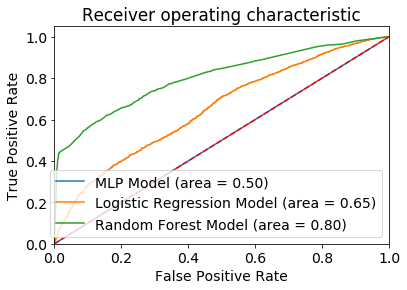

In [18]:

#Plot ROC curves to test your date ranged predictions for accuracy 

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

nn_roc_auc = roc_auc_score(y_test, X_test_copy['preds_mlp'])
nn_roc_auc2 = roc_auc_score(y_test, X_test_copy['preds_log'])
nn_roc_auc3 = roc_auc_score(y_test, X_test_copy['preds_rfm'])

fpr, tpr, thresholds = roc_curve(y_test, X_test_copy['preds_mlp'])

fpr2, tpr2, thresholds2 = roc_curve(y_test, X_test_copy['preds_log'])

fpr3, tpr3, thresholds3 = roc_curve(y_test, X_test_copy['preds_rfm'])

plt.figure()

plt.plot(fpr, tpr, label='MLP Model (area = %0.2f)' % nn_roc_auc)
plt.plot(fpr2, tpr2, label='Logistic Regression Model (area = %0.2f)' % nn_roc_auc2)
plt.plot(fpr3, tpr3, label='Random Forest Model (area = %0.2f)' % nn_roc_auc3)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [19]:
#function via https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [20]:
##How would I expect the model to perform?
from sklearn.metrics import confusion_matrix
X_test_pred = np.where(rfm.predict(X_test) >= thresholds3[np.argmax(tpr3 - fpr3)],1,0)
pd.crosstab(X_test_pred,y_test)

churn,0,1
row_0,,
0,8859,1537
1,38,352


Normalized confusion matrix
[[0.9957289  0.0042711 ]
 [0.81365802 0.18634198]]


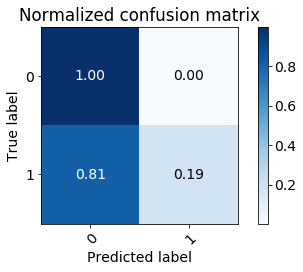

In [21]:
class_names = df.churn.unique()
cm = plot_confusion_matrix(y_test, X_test_pred, classes=class_names,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)

In [24]:
#What are the most important features?
feature_importances

,importance
TurnAutoRenewOff,0.299635
AutoRenewOn_no,0.181055
BeginningState_Renewal,0.103515
MaxContinuousActiveMonths,0.097124
TenureMonth,0.064875
StartTrial,0.063525
NActiveMonths,0.056777
NContinuousActiveMonths,0.046568
ClipsPerActiveDay,0.025512
NPrevChurns,0.024509


In [23]:
###Does removing features with feature importance improve model?
###Did not try any feature reduction or cross-validation but that can be done
###in future iterations.


#importance_threshold = 0.01
#frm_x_train_df = X_train[X_train.columns[X_train.columns.isin(feature_importances[feature_importances.values>importance_threshold].index)]]
#frm_x_test_df = X_test[X_test.columns[X_test.columns.isin(feature_importances[feature_importances.values>importance_threshold].index)]]